# Velocity and pumping diagnostics after PharaGlow analysis

## Changing names (user input required)

#### Strain directories

In [5]:
# ADD DIRECTORY OF STRAIN MASTER FOLDER(S)
ctrl = "/media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/"
INF100 = "/media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_batch/INF100/"
INF102 = "/media/scholz_la/soma/Nicolina/INF102/RFP_24h/10x/10x_INF102_analyzed/"
INF103 = "/media/scholz_la/soma/Nicolina/INF103/RFP_24h/10x/10x_INF103_analyzed/"
INF5 = "/media/scholz_la/soma/Nicolina/INF5/RFP_24h/10x/10x_INF5_analyzed/"

# FINAL FIGURE NAME AND DIRECTORY (figure name MUST have .pdf at the end) - if not changed then the previous figure
# WILL be erased so be careful!
avgplot = "/home/nzjacic/Desktop/10x_diagnostics_average_{}.pdf"
singleplot = "/home/nzjacic/Desktop/10x_diagnostics_single_{}.pdf"

#### Dictionary linking strain names to their folders and graph colors

In [6]:
# ADD STRAIN NAMES
strains = ['Control', 'INF100', 'INF102', 'INF103', 'INF5']

# ADD DIRECTORY VARIABLE
directories = [ctrl, INF100, INF102, INF103, INF5]

# ADD COLORS
# if a syntax error comes up it's probably because you forgot to add a comma after the previous strain name
colors = {
        'INF100':'red',
        'Control':'blue',
        'INF102' :'green',
        'INF103':'orange',
        'INF5':'purple'
    }

#### Variables

In [7]:
# FPS?
fps = 30

# HOW MANY MICRONS PER PIXEL?
umPerPx = 2.34

# HOW LONG BEFORE AND AFTER ENTRY WORM ENTRY TO PLOT (IN FRAMES)
tBefore = 70*fps
tAfter = 10*fps

## Extracting velocity and pumping information

### Importing packages

In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import pickle
# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import extract, util
from pharaglow.util import smooth

### Defining functions and dictionaries

#### Defining functions to extract velocity, pumping and kymo

In [9]:
def getVelocity(traj, umperPx, fps):
    return np.sqrt((np.diff(traj['x'])**2+np.diff(traj['y'])**2))/np.diff(traj['frame'])*umperPx*fps

def getPumps(pumps, ws = 30, prs = np.linspace(0.5,0.95,50) ):
    return extract.bestMatchPeaks(pumps, ws, prs)

def getKymo(df, key):
    kymo = np.sum([np.array(list(filter(None.__ne__,row))) for row in df[key].values], axis=2)
    kymo = np.array([np.interp(np.linspace(0, len(row), 100), np.arange(len(row)), np.array(row)) \
                      for row in kymo])
    kymo = extract.alignKymos(kymo).T
    return kymo

#### Defining how Python reads in Pharaglow and lawn data

In [10]:
def getVelocity(traj, umperPx, fps):
    return np.sqrt((np.diff(traj['x'])**2+np.diff(traj['y'])**2))/np.diff(traj['frame'])*umperPx*fps

def getPumps(pumps, ws = 30, prs = np.linspace(0.5,0.95,50) ):
    return extract.bestMatchPeaks(pumps, ws, prs)

def getKymo(df, key):
    kymo = np.sum([np.array(list(filter(None.__ne__,row))) for row in df[key].values], axis=2)
    kymo = np.array([np.interp(np.linspace(0, len(row), 100), np.arange(len(row)), np.array(row)) \
                      for row in kymo])
    kymo = extract.alignKymos(kymo).T
    return kymo

def readData(dataFolder, umPerPx, fps, j = 0, nmax = None):
    df = {}
    path = os.path.dirname(dataFolder)
    for fn in os.listdir(path):
        if nmax != None and len(df.keys())>nmax-1:
            break
        file = os.path.join(path,fn)
        if os.path.isfile(file) and 'results_' in fn and fn.endswith('.json'):
            print('Reading', file)
            particle_index = int(fn.split('.')[0].split('_')[-1])
            traj =  pd.read_json(file, orient='split', numpy = True)
            # velocity
            t = traj['frame']/fps
            v = getVelocity(traj, umPerPx, fps)
            # pumping related data
            kymo = getKymo(traj, 'Straightened')
            rawPump = [-np.max(np.std(sIm, axis =1), axis =0) for sIm in traj['Straightened']]
            traj['pump'] = rawPump
            prs =  np.linspace(0.15,1.00,50)
            p, pump, pks, roc, metric  = getPumps(traj['pump'].values, prs = prs)
            #plotPumpAnalysis(pump, pks, roc, prs, time = traj['frame'], metric=metric)
            pinterp = np.interp(traj['frame'], p[:-1]+traj['frame'].iloc[0], fps/np.diff(p))
            # get a binary trace where pumps are 1 and non-pumps are 0
            tmp = np.zeros(len(t))
            tmp[p] = 1
            
            df[j] = {'time': t.values,
                     'x': traj['x'].values,
                     'y': traj['y'].values,
                             'velocity':v,
                             'peaks': p.values,
                             'pumpTrace':pump,
                             'binaryPumps': tmp,
                             'pumpInterp': pinterp,
                             'inside': traj['inside'].values,
                             'insideF': traj['insideHeadIntensity'].values,
                             'pid':particle_index,
                             'filename': fn,
                             'kymo': kymo,
                             'fps': fps,
                             'scale':umPerPx
                            }
            j +=1
    return df

#### Defining entry time

In [11]:
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

def getEntryTime(data, method = 'binary', window = 30):
    if method =='binary':
        # get the first entry from binarized lawn data. data should be the 'inside' variable from pharaglow
        t0 = np.where(data ==1)[0]
    if method =='fluorescence':
        data = pd.Series(data)
        data -= data.mean()
        data /= data.std()
        t0 = np.where(data>0)[0]
    if len(t0)>0:
       # plt.axvline(t0[0])
        return t0[0]
    else:
        return np.nan

### Helper functions to generate aligned velocity and pumping data
def alignData(df, tBefore, tAfter):
    """df is a dictionary created in readData. We will find the point of lawn entry and align and crop data to
    tBefore, TAfter. tBefore, tAfter are in frames."""
    for idx in df.keys():
        # identify the inside point t0 or set a flag that it doesn't enter
        try:
            # t0 is in frames not seconds!
            # CAN SWAP BETWEEN BINARY AND FLUORESCENT DETECTION OF LAWN ENTRY HERE
            t0 = getEntryTime(df[idx]['insideF'], method = 'fluorescence')
            #t0 = getEntryTime(df[idx]['inside'], method = 'binary')
            print(t0, np.mean(df[idx]['inside']))
            if t0 > tBefore and len(df[idx]['inside']) > t0+tAfter:
                # update the data
                df[idx]['t0'] = t0
                df[idx]['enter'] = True
            else:
                df[idx]['t0'] = None
                df[idx]['enter'] = False
        except IndexError:
            df[idx]['t0'] = None
            df[idx]['enter'] = False
        # calculate cropped versions of the data for animals that entered the lawn
        if df[idx]['enter']:
            for dname in ['insideF', 'velocity', 'time', 'pumpTrace', 'binaryPumps', 'pumpInterp']:
                df[idx][dname+'Cut'] = df[idx][dname][df[idx]['t0']-tBefore: df[idx]['t0']+tAfter+1]
            # peaks and other info
            df[idx]['peaksCut'] = df[idx]['peaks'][(df[idx]['peaks'] > df[idx]['t0']-tBefore)&
                                    (df[idx]['peaks'] < df[idx]['t0']+tAfter+1)]
            #shift the cut peaks to the correct locations relative to cut window
            df[idx]['peaksCut'] =  df[idx]['peaksCut'] - df[idx]['t0']+tBefore
            df[idx]['timeEntry'] = np.arange(-tBefore, tAfter+1)
            df[idx]['tBefore'] = tBefore
            df[idx]['tAfter'] = tAfter
    return df

#### Defining average plotting function

In [17]:
def graphing(Data, condition, plotpath, method = 'single', save = 'Yes'):
    # setting up GridSpec
    f1 = plt.figure(figsize = (16,4))
    grid = mpl.gridspec.GridSpec(ncols=3, nrows = 1, hspace = 0.3)
    # creating subplots
    axa = f1.add_subplot(grid[0,0])
    axb = f1.add_subplot(grid[0,1])
    axc = f1.add_subplot(grid[0,2])
    # axes dictionary
    axes = {
        'xlabel':'Time(s)',
        'ylabelv':'Velocity (um/s)',
        'ylabelp':'Pumping rate (Hz)',
        'ylabelf' : 'Fluorescence'
    }
    # extracting necessary data
    t, v, pr, f = [], [], [], []
    for idx in Data.keys():
        if Data[idx]['enter']:
            # pumping rate using rolling mean rate in a rolling 1 second window
            tAfter = Data[idx]['tAfter'] 
            #tmp = pd.Series(df[idx]['binaryPumpsCut']).rolling(fps).sum()
            tmp = Data[idx]['pumpInterpCut']
            t.append(Data[idx]['timeEntry']/Data[idx]['fps'])
            pr.append(tmp)
            v.append(Data[idx]['velocityCut'])
            f.append(Data[idx]['insideFCut']/np.max(Data[idx]['insideFCut']))
    print ('Plotting', condition+'...')
    if method == 'average':
        mv, sv = np.mean(np.array(v), axis =0), np.std(np.array(v), axis =0)
        time = np.mean(t, axis=0)
        axa.plot(time, mv, color = colors[condition], alpha = 0.7)
        axa.fill_between(time, mv-sv, mv+sv, 
                             color = 'gray', alpha = 0.3)
    if method == 'single':
        time = t
        axa.plot(time, v, color = colors[condition], alpha = 0.1)
    #axa.axvline(x = Data[idx]['timeEntry']/Data[idx]['fps'], color = 'black', dashes = (5, 2))
    axa.axvspan( 0, tAfter/Data[idx]['fps'], color='k', alpha=0.3)
    # making it pretty
    axa.annotate('n = '+str(len(v)), (0.8, 0.8), xycoords='axes fraction')
    axa.set_ylabel(axes['ylabelv'])
    axa.set_xlabel(axes['xlabel'])
    axa.set_ylim(0,200)
    # pumping rate across all trajectories and all movies per strain
    if method == 'average':
        mp, sp = np.mean(np.array(pr), axis = 0), np.std(np.array(pr), axis =0)
        axb.plot(time, mp, color = colors[condition], alpha = 0.5)
        axb.fill_between(time, mp-sp, mp+sp, 
                 color = 'gray', alpha = 0.3)
        axb.plot(time, smooth(mp, 50), 'black', lw =2)
    if method == 'single':
        axb.plot(time, pr, color = colors[condition], alpha = 0.1)
    #axb.axvline(x = Data[idx]['timeEntry']/Data[idx]['fps'], color = 'black', dashes = (5, 2))
    axb.axvspan( 0, tAfter/Data[idx]['fps'], color='k', alpha=0.3)
    # making it pretty
    axb.annotate('n = '+str(len(pr)), (0.8, 0.8), xycoords='axes fraction')
    axb.set_ylabel(axes['ylabelp'])
    axb.set_xlabel(axes['xlabel'])
    axb.set_ylim(0,6)
    # fluorescence sanity check
    if method == 'average':
        mf, sf = np.mean(np.array(f), axis =0), np.std(np.array(f), axis =0)
        axc.plot(time, mf, color = colors[condition], alpha = 0.7)
        axc.fill_between(time, mf-sf, mf+sf, 
                             color = 'gray', alpha = 0.3)
    if method == 'single':
        axc.plot(time, f, color = colors[condition], alpha = 0.1)
    #axa.axvline(x = Data[idx]['timeEntry']/Data[idx]['fps'], color = 'black', dashes = (5, 2))
    axc.axvspan( 0, tAfter/Data[idx]['fps'], color='k', alpha=0.3)
    # making it pretty
    axc.annotate('n = '+str(len(f)), (0.8, 0.8), xycoords='axes fraction')
    axc.set_ylabel(axes['ylabelf'])
    axc.set_xlabel(axes['xlabel'])
    axc.set_ylim(0,1)
    # setting axes titles
    if method == 'average':
        axa.set_title('Average Velocity of Trajectories per Video')
        axb.set_title('Pumping Rate (Hz) of Trajectories per Video')
        axc.set_title('Average Fluorescence')
    if method == 'single':
        axa.set_title('Velocity of all Trajectories per Video')
        axb.set_title('Pumping Rate (Hz) of Trajectories per Video')
        axc.set_title('Fluorescence')
    # saving data variable
    plotpath = plotpath.format(condition)
    print('Ta da!')
    # OPTIONAL - save figure
    if save == 'Yes':
        print(plotpath)
        plt.savefig(plotpath)
    else:
        print('Not saved')

#### Defining saving and loading process

In [13]:
def readPharaglow(strains, directories, index, save=True):
    Data = readData(directories[index], umPerPx, fps, nmax = None)
    if save:
        saveData = open(f'/home/nzjacic/Desktop/Diagnostics/Saved_data/{strains[index]}', 'wb')
        pickle.dump(Data, saveData)
        saveData.close()

In [14]:
def loadPharaglow(strains, directories, index):
    saveData = open(f'/home/nzjacic/Desktop/Diagnostics/Saved_data/{strains[index]}', 'rb')
    Data = pickle.load(saveData)
    saveData.close()
    return Data

### Reading and Graphing (add as strains increase)

#### Control

In [15]:
#readPharaglow(strains, directories, index=0)

1527 0.22931541369172617
1031 0.42
0 1.0
3 1.0
0 0.9001837109614207
21 0.0
765 0.67896432936993
28 1.0
0 0.7029702970297029
606 0.7955328369818869
1417 0.6038461538461538
1268 0.7568466854363962
1051 0.4095260062276554
780 0.5565749235474006
690 0.9101823032458871
506 0.7142123507510592
0 0.9833948339483395
0 0.21636675235646957
0 1.0
1 1.0
763 0.26287262872628725
499 0.7072784810126582
1909 0.6668369084099421
1 0.5891052040434295
3035 0.565921052631579
760 0.8366268831931128
1686 0.6436498150431565
1369 0.7354150461162351
1140 0.5116904058048911
32 0.940570984657215
536 0.6356925749023014
0 0.7688723205964585
57 0.5004760393525864
3 0.0
929 0.3795977330814535
116 0.026150188784785346
0 0.33670774647887325
1927 0.2504668534080299
92 0.49779411764705883
0 0.8372781065088757
6 0.0
5656 0.22435826202911435
1544 0.22213579286587398
899 0.2614889705882353
0 0.0
876 0.1052019761697181
1182 0.4456074124914207
Plotting Control...
Ta da!
Not saved


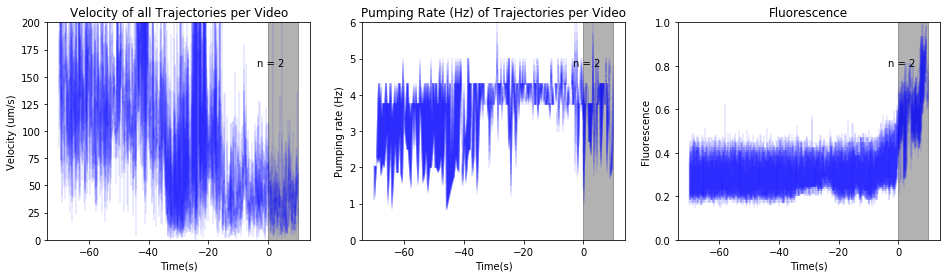

In [18]:
Data = loadPharaglow(strains, directories, index=0)
Data = alignData(Data, tBefore=tBefore, tAfter=tAfter)
# change plot variable and method
graphing(Data, strains[0], singleplot, method = 'single', save = 'No')

Text(0.5, 0, 'Velocity (um/s)')

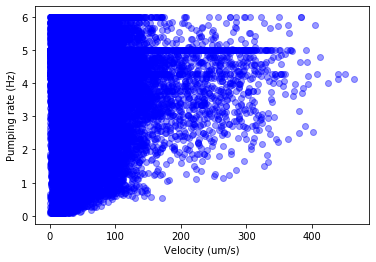

In [30]:
v, pr = [], []
for idx in Data.keys():
    if Data[idx]['enter']:
        # pumping rate using rolling mean rate in a rolling 1 second window
        #tmp = pd.Series(df[idx]['binaryPumpsCut']).rolling(fps).sum()
        tmp = Data[idx]['pumpInterpCut']
        pr.append(tmp)
        v.append(Data[idx]['velocityCut'])
plt.scatter(v, pr, color = 'blue', alpha = 0.4)
plt.ylabel('Pumping rate (Hz)')
plt.xlabel('Velocity (um/s)')

#### INF100

In [13]:
#readPharaglow(strains, directories, index=1)

1364 0.5886209578842093
0 1.0
1350 0.6319093762795142
1176 0.00786434013271074
1292 0.12222222222222222
23 0.0
29 0.0
1666 0.012641815235008104
2797 0.6365090244459676
2401 0.6073419442556084
3097 0.5367902665121669
2124 0.60238933986828
915 0.0
3 0.0
160 0.0
1339 0.38351581508515814
13 0.0
197 1.0
2321 0.08575380359612725
24 0.9577039274924471
1340 0.45514463566459173
1540 0.09161894846434149
1509 0.0
6 0.0
1630 0.6717313824798349
1488 0.6620012533946104
4366 0.17857708762478214
22 0.0
0 0.0
1722 0.7103816300129366
1872 0.2703210382513661
1948 0.4968911917098446
0 0.0
336 0.0
1678 0.38218205293737895
1603 0.0676148286313826
1828 0.48762886597938143
1985 0.18985849056603774
1346 0.5691569156915691
1 0.0
83 0.0
0 0.0
1702 0.24771949828962372
5 0.0
2 0.0
3 0.0
0 0.0
1 0.0
1 0.0
3073 0.6229294841457643
22 0.0
4 0.0
0 0.0
5 0.0
11 0.0
2 0.0
3 0.0
1712 0.12496704455576062
1140 0.2740083507306889
5 0.0
92 0.0
0 0.0
2396 0.5060091905266879
1 0.0
0 0.0
97 0.0
1 1.0
6 1.0
2758 0.346808253891637

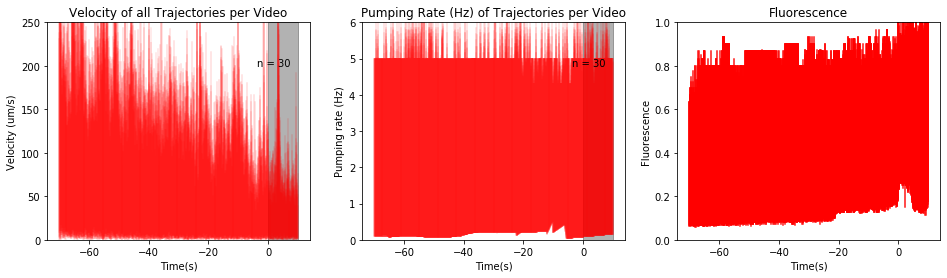

In [52]:
Data = loadPharaglow(strains, directories, index=1)
Data = alignData(Data, tBefore=tBefore, tAfter=tAfter)
graphing(Data, strains[1], singleplot, method = 'single', save = 'Yes')

#### INF102

In [15]:
#readPharaglow(strains, directories, index=2)

383 0.9811725846407927
1 0.0
6866 0.0344490328189524
3 0.0
1 0.0
0 0.0
0 0.0
2 0.0
2 0.0
1 0.0
0 0.0
3946 0.2495203990280087
3858 0.07368421052631578
744 0.49159663865546216
12 0.0
0 0.8715538847117794
1 0.0
5 0.0
3523 0.4271444426827335
1 0.0
80 0.0
571 0.0
154 0.0
0 0.0
800 0.0
16 0.0
0 0.0
7 0.0
545 0.3165137614678899
1143 0.7196927529778471
0 0.46563814866760167
0 1.0
25 0.0
2 0.0
2 0.0
2 0.0
2957 0.040811021575253445
1 0.0
4 0.0
7 0.0
3 0.0
0 0.0
0 0.0
1 0.0
0 0.0
4545 0.5398544592993738
0 0.3605143484397052
241 0.6102088167053364
5080 0.19844983913424977
1 0.0
2956 0.1554739797020082
2 0.0
1 0.0
1 0.0
3755 0.3429655339413996
2 0.0
0 0.40657276995305164
0 1.0
0 0.0
0 0.5776722090261283
1 0.6878824969400245
8 0.0
0 0.0
2 0.0
0 0.0
2 0.0
0 0.0
2 0.0
2 0.0
319 0.8116846284741918
580 0.47084708470847086
2543 0.5791746641074856
85 0.8861578266494179
0 0.41506849315068495
2952 0.2505260552048521
65 1.0
0 0.0
1 0.0
0 0.0
0 0.9577142857142857
21 0.0
5 0.0
1 0.0
0 0.0
0 0.0
12 0.0
3671 0.2

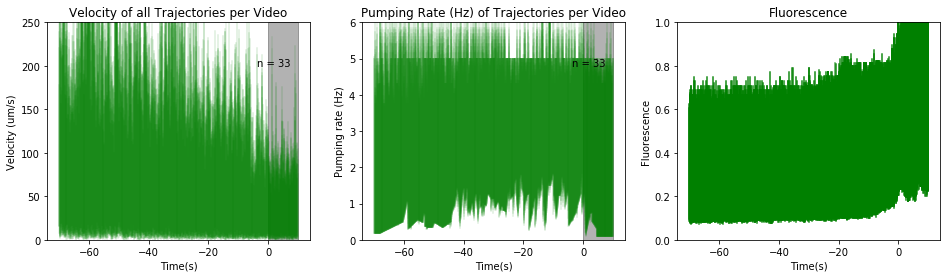

In [53]:
Data = loadPharaglow(strains, directories, index=2)
Data = alignData(Data, tBefore=tBefore, tAfter=tAfter)
graphing(Data, strains[2], singleplot, method = 'single', save = 'Yes')

#### INF103

In [17]:
#readPharaglow(strains, directories, index=3)

919 0.018821198613174838
1156 0.46584699453551914
3 1.0
2 0.0
6 0.0
571 0.025530073561228904
1166 0.13295880149812733
1009 0.17381404174573056
1779 0.26229508196721313
0 0.5192092502797464
936 0.8257667068434444
0 0.6628003314001657
0 0.0
0 1.0
1 0.9629629629629629
1921 0.3843774168600155
2473 0.5788296682817742
981 0.5432900432900433
1639 0.29614767255216695
195 0.044265887509130755
45 0.9593160377358491
3 0.0
4 1.0
0 1.0
0 1.0
762 0.5506519558676028
0 1.0
0 0.7111496244945118
4 0.0
475 0.48868778280542985
2992 0.5135009310986964
112 1.0
0 0.11301044634377967
0 0.9945474372955289
3 0.8975609756097561
422 0.0
0 0.00522875816993464
0 1.0
41 1.0
0 0.6006475984889369
1 0.0
1231 0.13070440451582127
0 0.8687350835322196
834 0.054777845404747415
0 1.0
0 0.24631956912028724
298 0.7988980716253443
831 0.13031275060144346
616 0.6906966490299824
3 0.0
1443 0.5854505971769816
1120 0.6329830234438156
1350 0.21673342234089898
0 0.23620662082200544
9 0.10916179337231968
35 1.0
1211 0.617398831421770

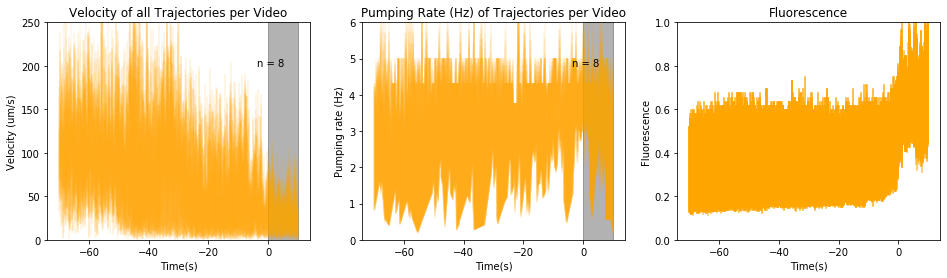

In [54]:
Data = loadPharaglow(strains, directories, index=3)
Data = alignData(Data, tBefore=tBefore, tAfter=tAfter)
graphing(Data, strains[3], singleplot, method = 'single', save = 'Yes')

#### INF5

In [19]:
#readPharaglow(strains, directories, index=4)

1 0.0
1 0.0
0 0.0
540 0.0
1159 0.0
4577 0.16193931398416886
2 0.0
137 0.007000777864207134
0 0.0
1194 0.415088230532621
3905 0.3869361894705084
10 0.0
4 0.0
154 0.0
1 0.0
0 0.0
1300 0.2823654768247203
1 0.0
590 0.0
2117 0.4358262029114346
0 1.0
0 0.0
0 0.0
1955 0.7939442390326771
0 0.0
1 0.0
0 1.0
5157 0.34892765862873654
2 0.0
0 0.0
1634 0.2743559565842814
1 0.0
2 0.0
4565 0.4370699223085461
0 0.0
5 0.0
68 0.0
2 0.0
1 0.0
92 0.0
2 0.0
5 0.0
0 1.0
18 0.0
0 0.0
1120 0.11926353393789503
0 0.0
0 0.0
27 0.0
0 0.008443908323281062
7 0.0
1037 0.5918471337579618
218 0.0
8 1.0
1 0.0
6 0.0
3 0.0
0 1.0
4 0.9842041312272175
3 0.0
2 0.0
6 0.0
1 0.0
0 0.0
9 0.0
1 0.0
4 1.0
1 1.0
1 0.0
0 0.0
1 0.0
1 0.0
2191 0.0
5 0.0
0 0.0
12 0.0
0 0.0
2 0.0
0 0.0
1514 0.3646199241253337
25 1.0
0 0.0
5 0.0
21 0.0
16 0.0
1 0.0
0 1.0
2520 0.7181809514729717
20 0.0
5 0.0
8 0.0
12 1.0
25 0.0
3765 0.6592419615591881
5 0.0
544 0.9211023447049672
2 0.10172655156322911
1 1.0
65 0.8980044345898004
4 0.0
1753 0.6291322314049

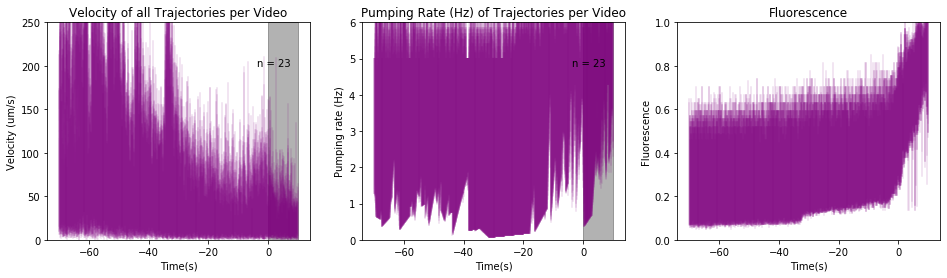

In [62]:
Data = loadPharaglow(strains, directories, index=4)
Data = alignData(Data, tBefore=tBefore, tAfter=tAfter)
graphing(Data, strains[4], singleplot, method = 'single', save = 'Yes')